In [50]:
#!/usr/bin/python

from IPython.display import Image
import sys
import pickle
from matplotlib import pyplot as plt
import os
import pprint
import pandas as pd
import seaborn as sns
import time

%matplotlib inline


sys.path.append("../tools/")


In [51]:
os.getcwd()

'F:\\Users\\Me\\Google Drive\\Udacity\\Data_Science_Nano_Degree\\Intro_to_machine_learning\\ud120-projects\\final_project'

In his presentation "Machine Learning Gremlins" Ben Hammer suggests the following process model for tackling machine learning problems:

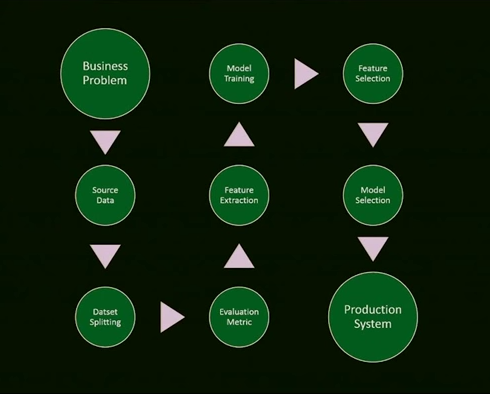

In [52]:
Image(filename='Machine-Learning-Process.png') 

Common issues to look at for include:

* Data leakage
    - introducing information about your classification target which has nothing to to with the actual target
        - grass in background of dog photos
        - previous prostate surgery for identifying prostate cancer
    - to avoid:  it is important to understand what the most important variables are in your model and how they are being used
* Overfitting
    - to avoid:  pay close attention to training error vs validation error or k-fold cross validation
    - make sure to split the data into training and testing sets

#Task 0:  Explore the data
Before getting into the machine learning exercies, we first need to load and explore the Enron dataset.

In [53]:
#navigate up one folder with "../" prefix
#we need to deserialize, extract the data structure from byte code, using the pickle module
enron_data = pickle.load(open("../final_project/final_project_dataset.pkl", "r"))

Now let's look at the type of data structure and the size of it

In [54]:
print ("Data type: {}".format(type(enron_data)))
data_entries = len(enron_data)
print("length of Enron dictionary is {}".format(data_entries))

Data type: <type 'dict'>
length of Enron dictionary is 146


So we have a dictionary of lengh 146. Let's see what's in it:

In [55]:
#for data in enron_data:
#    print (data, enron_data[data])

Given that the dictionary keys for enron_data are people let's print out the list of attributes for each person:

In [56]:
pprint.pprint(enron_data["METTS MARK"])
features = len(enron_data["METTS MARK"])
print("\n Each person in the Enron dataset has {} features".format(features))

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

 Each person in the Enron dataset has 21 features


Now let's identify hom many poi's are in the dataset?

In [57]:
def poi_count():
    poi_count = 0
    for i in enron_data:
        #print enron_data[i]["poi"]
        if enron_data[i]["poi"] == True:
            poi_count += 1
    return "total poi count = %s" %poi_count

poi_count()  

'total poi count = 18'

With 18 poi's, we have 128 non-poi's (146-18).  Now let's look at the number of NaN's in the dataset for each feature:

In [58]:
NaNs = {}
for person in enron_data:
    for feature in enron_data[person]:
        if enron_data[person][feature] == "NaN":
            if feature in NaNs:
                NaNs[feature] += 1.
            else:
                NaNs[feature] = 1.

pprint.pprint(NaNs)



{'bonus': 64.0,
 'deferral_payments': 107.0,
 'deferred_income': 97.0,
 'director_fees': 129.0,
 'email_address': 35.0,
 'exercised_stock_options': 44.0,
 'expenses': 51.0,
 'from_messages': 60.0,
 'from_poi_to_this_person': 60.0,
 'from_this_person_to_poi': 60.0,
 'loan_advances': 142.0,
 'long_term_incentive': 80.0,
 'other': 53.0,
 'restricted_stock': 36.0,
 'restricted_stock_deferred': 128.0,
 'salary': 51.0,
 'shared_receipt_with_poi': 60.0,
 'to_messages': 60.0,
 'total_payments': 21.0,
 'total_stock_value': 20.0}


Several features have a lot of NaNs.  Features with the highest number of NaNs are unlikely to be useful as features in our model.

In [59]:
#here we find the percentage of NaNs for each feature to aid in feature selection
for feature in NaNs:
    NaNs[feature] = NaNs[feature]/data_entries

pprint.pprint(NaNs)
        

{'bonus': 0.4383561643835616,
 'deferral_payments': 0.7328767123287672,
 'deferred_income': 0.6643835616438356,
 'director_fees': 0.8835616438356164,
 'email_address': 0.23972602739726026,
 'exercised_stock_options': 0.3013698630136986,
 'expenses': 0.3493150684931507,
 'from_messages': 0.410958904109589,
 'from_poi_to_this_person': 0.410958904109589,
 'from_this_person_to_poi': 0.410958904109589,
 'loan_advances': 0.9726027397260274,
 'long_term_incentive': 0.547945205479452,
 'other': 0.363013698630137,
 'restricted_stock': 0.2465753424657534,
 'restricted_stock_deferred': 0.8767123287671232,
 'salary': 0.3493150684931507,
 'shared_receipt_with_poi': 0.410958904109589,
 'to_messages': 0.410958904109589,
 'total_payments': 0.14383561643835616,
 'total_stock_value': 0.136986301369863}


#Task 1:  Select Features

Here is a list of all the financial features available in the dataset:

In [60]:
financial_features = ["poi",  'bonus', 'deferral_payments', 'deferred_income', 
                      'director_fees', 'exercised_stock_options', 'expenses', 
                      'loan_advances', 'long_term_incentive', 'restricted_stock', 
                      'restricted_stock_deferred', 'salary', 'total_payments', 
                      'total_stock_value']

The cell below could be used to remove features that have more than 40% of entries that are NaN

In [61]:
def NaN_cutoff(cut_off):
    #let's remove from the list of financial_features any features where more than 40% of the data_entries are NaN
    for feature in NaNs:
        #print feature
        if feature in financial_features:
            if NaNs[feature] > cut_off:
                financial_features.remove(feature)

    return financial_features   

financial_features = NaN_cutoff(0.5)
financial_features

['poi',
 'bonus',
 'exercised_stock_options',
 'expenses',
 'restricted_stock',
 'salary',
 'total_payments',
 'total_stock_value']

#Task 2: Remove Outliers
## Explore outliers in the financial features

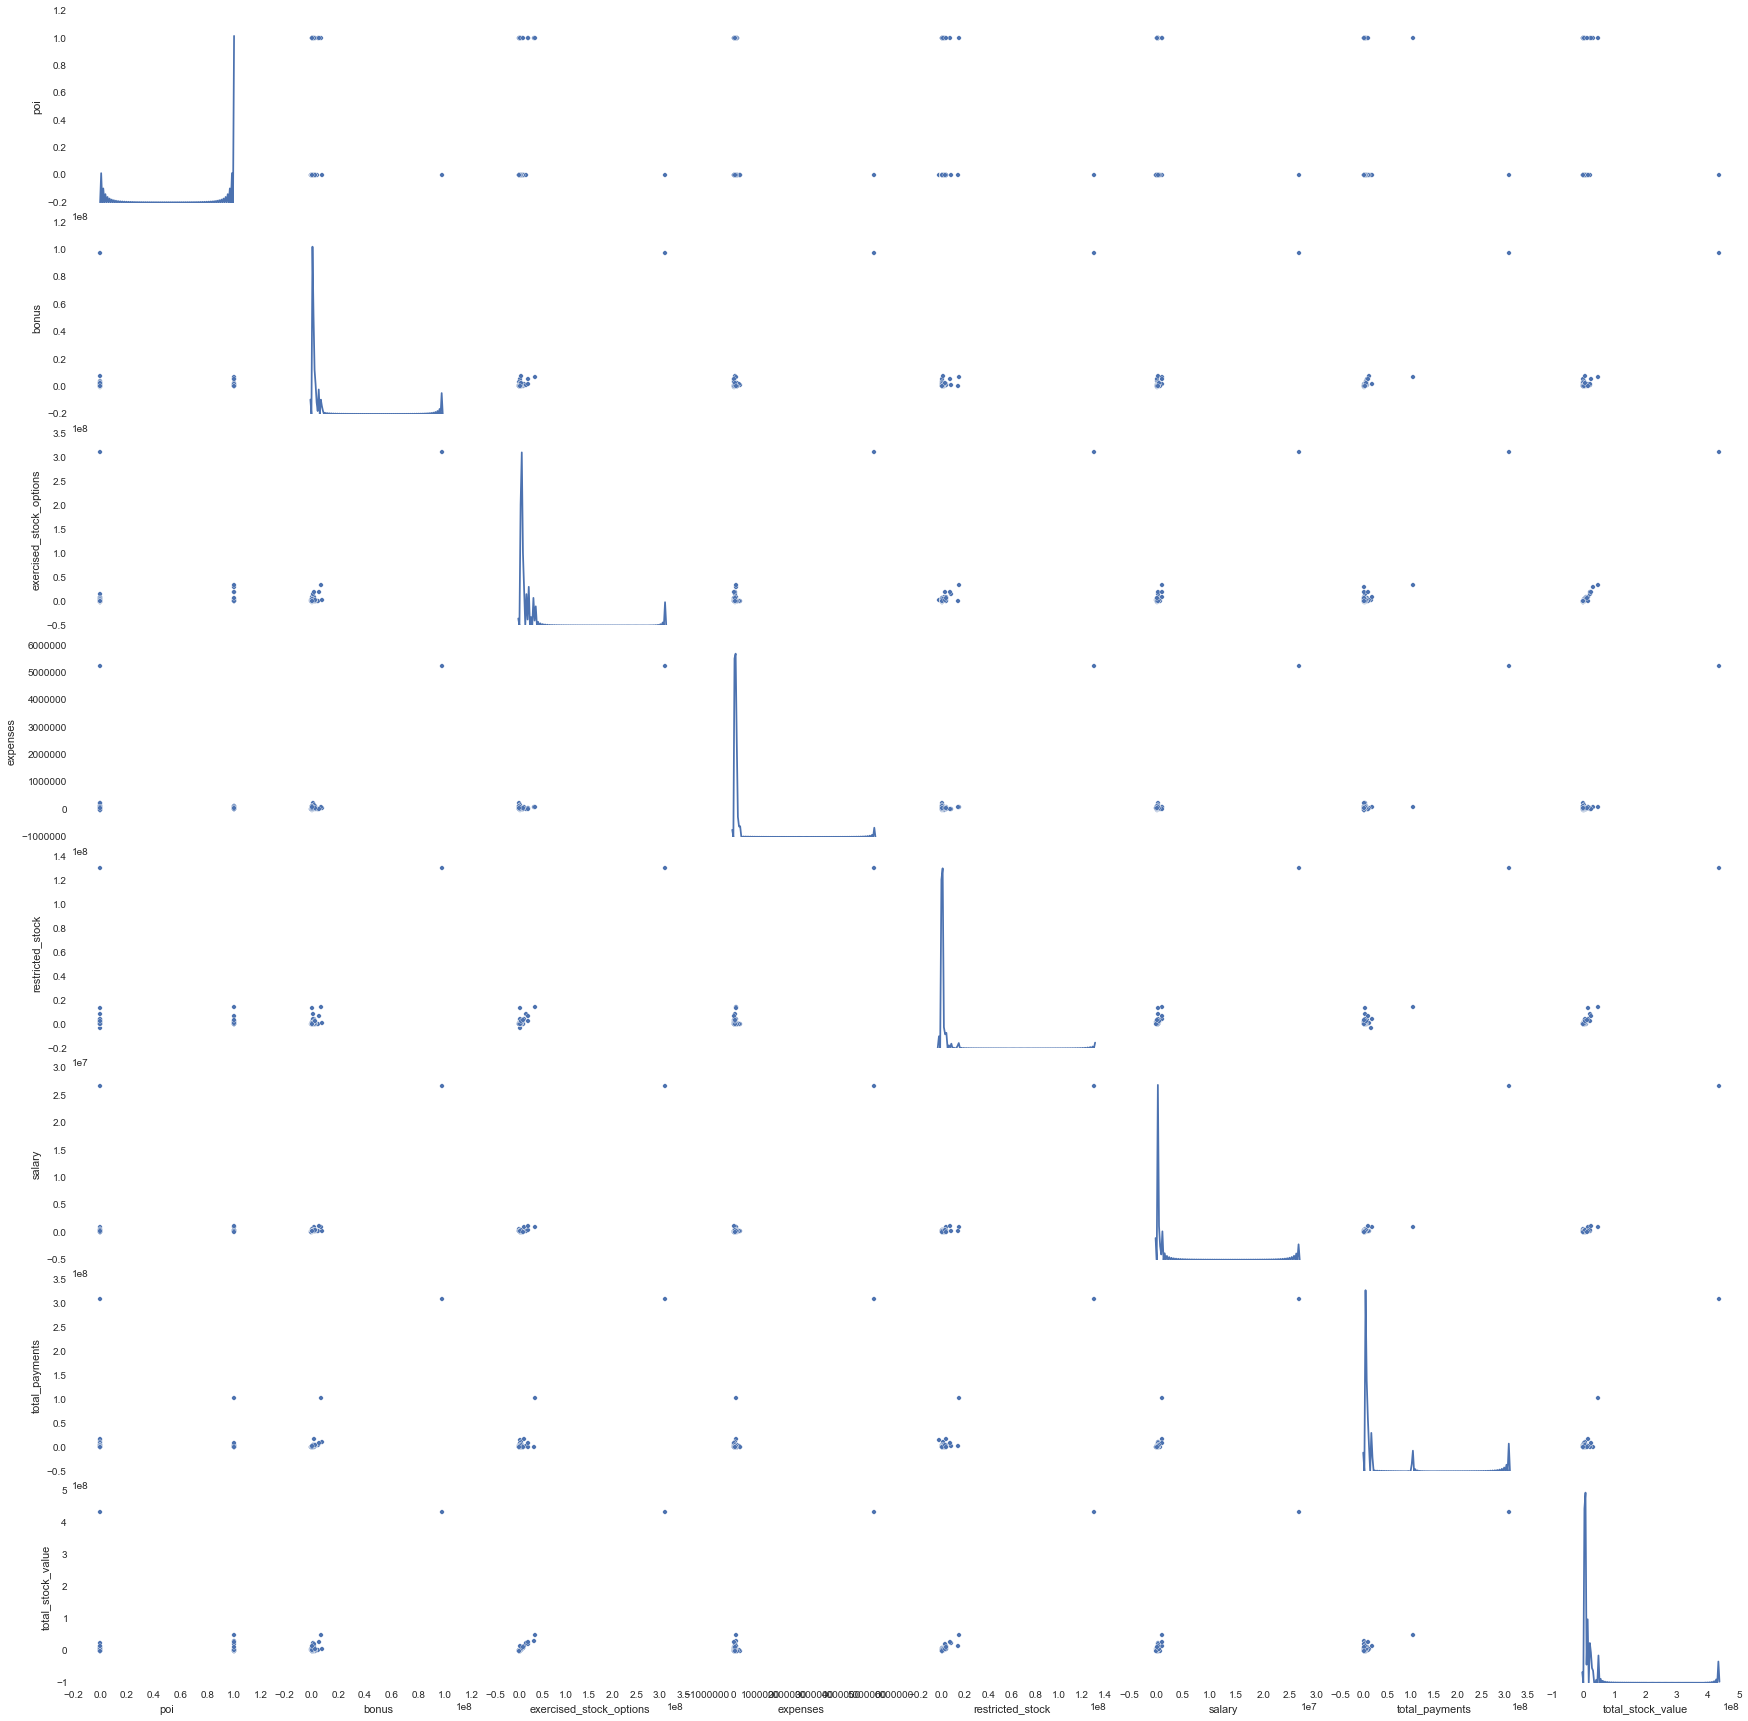

In [62]:
#let's put the financial features into a pandas dataframe and visualize their relationship
df = pd.DataFrame.from_dict(enron_data, orient = "index")#navigate up one folder with "../" prefix 
df_financial = df[financial_features]
sns.pairplot(df_financial, diag_kind="kde")

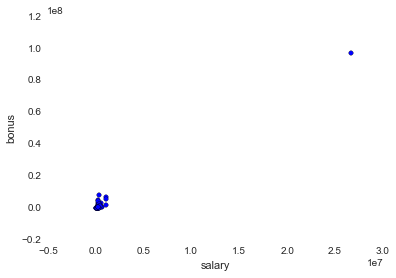

In [63]:
from feature_format import featureFormat, targetFeatureSplit
import matplotlib.pyplot as plt

features = ["salary", "bonus"]


def scatter(x, y):


    #Now plot the data again
    data = featureFormat(enron_data, features)

    for point in data:
        salary = point[0]
        bonus = point[1]
        plt.scatter( salary, bonus )
        plt.xlabel(x)
        plt.ylabel(y)
        
scatter(features[0], features[1])

It looks like we have a number of outliers as all of the data is clusstered in very small areas.  Let's take one financial data pair to investigate the outliers a little further.

Looks like we have a big outlier.  Let's see what the max salary is for the outlier

In [64]:
def max_feature(feature):
    feature_list = []
    for person in enron_data:
        if enron_data[person][feature] != "NaN":
            feature_list.append(enron_data[person][feature])
    return max(feature_list)
    
max_feature("salary")

26704229

Who does this outlier belong to?

In [65]:
def person(feature):
    for person in enron_data:
        if enron_data[person][feature] == max_feature(feature):
            return person
            #break
            
person("salary")

'TOTAL'

Let's remove this summary statistic and replot the data

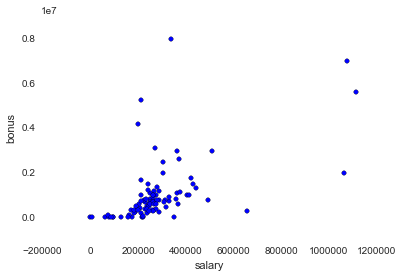

In [66]:
def remove(feature):
    for person in enron_data:
        if enron_data[person][feature] == max_feature(feature):
            enron_data.pop(person, 0 )
            break

remove("salary")
            
scatter(features[0], features[1])

There are stil a few outliers in the data

In [67]:
def salary_outliers():
    outliers = []
    for person in enron_data:
        if enron_data[person]["salary"] > 1000000 or enron_data[person]["bonus"]>5000000:
            if enron_data[person]["salary"] != "NaN" and enron_data[person]["bonus"] != "NaN":
                #print person, data_dict[person]["salary"], data_dict[person]["bonus"]
                outliers.append(person)
    print outliers
    
salary_outliers()

['LAVORATO JOHN J', 'LAY KENNETH L', 'BELDEN TIMOTHY N', 'SKILLING JEFFREY K', 'FREVERT MARK A']


Since the remaining outliers are all people, we'll keep them in the dataset.  But let's just check to see who all the biggest outliers are across all of the financial features:

In [68]:
for feature in financial_features:
    print"Person: ", person(feature),"Feature:", feature

Person:  HANNON KEVIN P Feature: poi
Person:  LAVORATO JOHN J Feature: bonus
Person:  LAY KENNETH L Feature: exercised_stock_options
Person:  MCCLELLAN GEORGE Feature: expenses
Person:  LAY KENNETH L Feature: restricted_stock
Person:  SKILLING JEFFREY K Feature: salary
Person:  LAY KENNETH L Feature: total_payments
Person:  LAY KENNETH L Feature: total_stock_value


Now let's replot the financial features with a scatter plot matrix

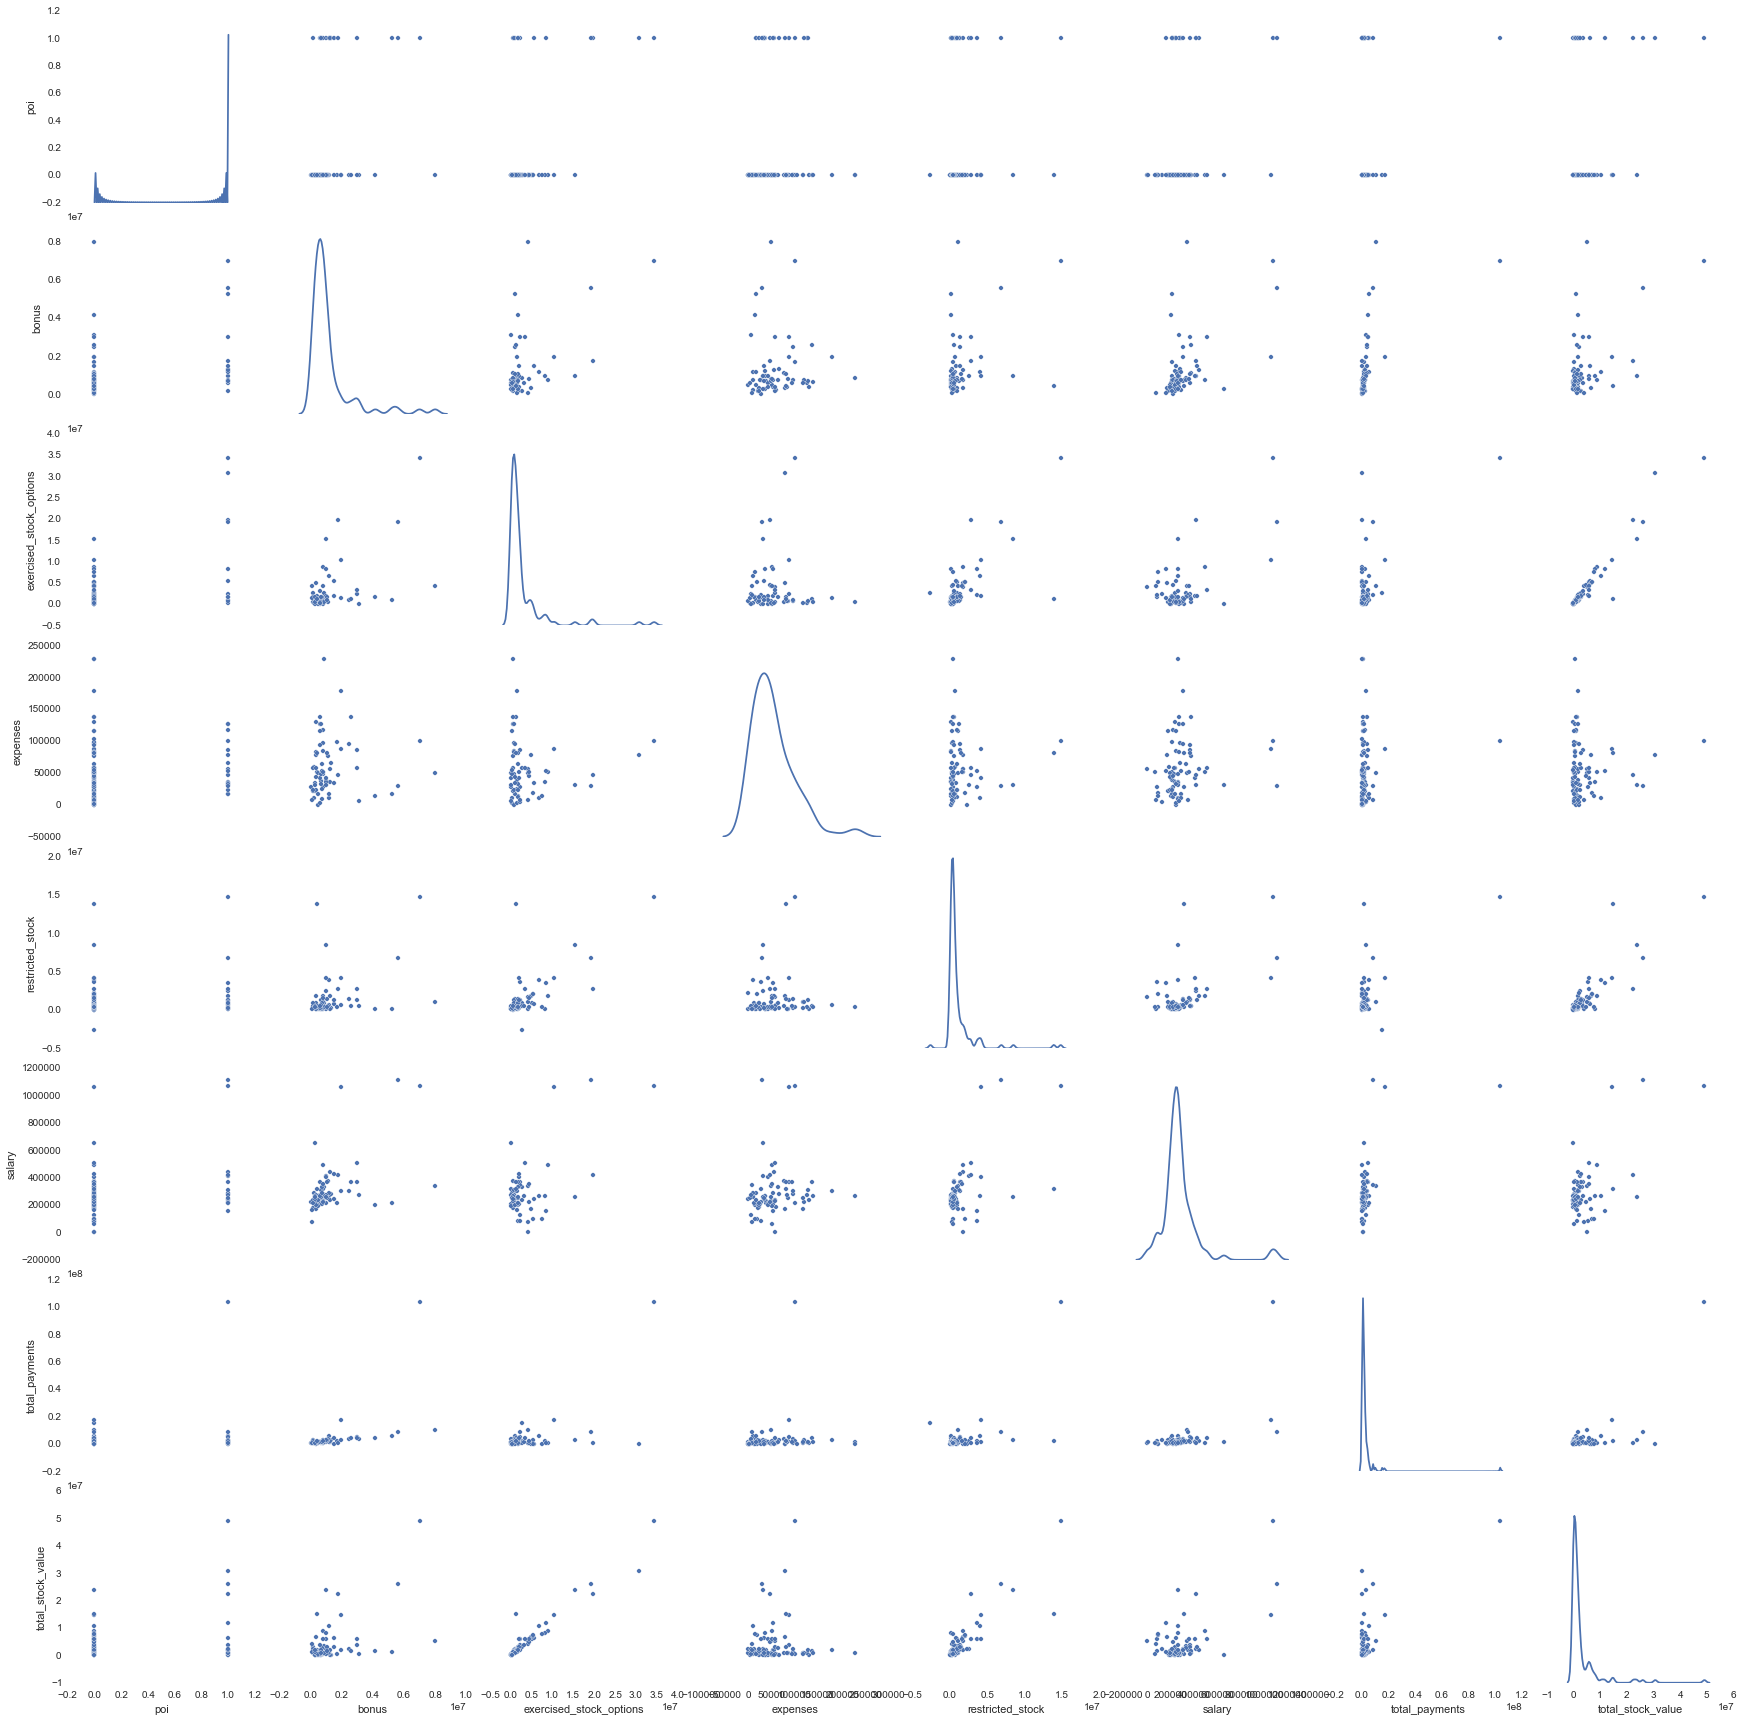

In [69]:
df = pd.DataFrame.from_dict(enron_data, orient = "index")
df_financial = df[financial_features]
sns.pairplot(df_financial, diag_kind="kde")

## Task 3:  Create new features
### 3.1 Preprocessing Data

In [70]:
from sklearn.pipeline import Pipeline

from sklearn.cross_validation import train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from tester import test_classifier, dump_classifier_and_data



###Step 1:  Re-formate data into a set of numpy arrays and split it into training and testing sets.
When selecting features, make sure to always train your model on a subset of the data to ensure the model isn't overfit.

In [71]:
#guided by lesson 6 regression

#first we need to format the financial features.  
#featureFormat takes a dictionary and a list of features, and returns a numpy array for each feature
#The first feature in the feature list is the poi classification.
#All NaNs are converted to 0, and data points are removed if all of the features are zero.  
data = featureFormat( enron_data, financial_features, remove_NaN =True, remove_all_zeroes = True)
#targetFeatureSplit splits the data into the target (i.e. poi classification) and features
target, features = targetFeatureSplit(data)


feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.5, random_state=42)

###Step 2:  Normalization

####Normalize Features
Now let's normalize the financial features before applying principle component analysis for feature reduction

In [72]:
scaler = MinMaxScaler()

feature_train_scaled = scaler.fit_transform(feature_train)
feature_test_scaled = scaler.fit_transform(feature_test)


###Step 3: Dimensionality Reduction
####Feature Selection & Dimensionality Reduction
Feature selection and dimensionality reduction are both processes of reducing the number of variables we consider in our analysis but the go about reducing the number of variables in different ways.  While features selection involves selecting the most important features (and excluding others from the analysis), dimensionality reduction involves combining features to make new features.  Principle component analysis is a great example of diminsionality reduction.  

[Jason Brownlee](http://machinelearningmastery.com/an-introduction-to-feature-selection/) identifies three general types of feature selection:

* Filter Methods,
* Wrapper Methods, and
* Embedded Methods

Embeded methods learn the best features while the model is being created.  Wrapper methods compare different combinations of features.  Filter methods apply statistical techniques to score each feature.  Below, recursive feature elimination (wrapper method) and two embedded methods - Lasso regression and linear support vector machine classification - are used to select financial features. 


####Principle Component Analysis

By setting n_components=3 below, we are reducing the n-dimensional space (where n=len(features)) to 3 principle component dimensions.  These principle components represent the 1st, 2nd, and 3rd dimensions of max variance and the principle components are orthogonal to each other.  If this is confusing, it should because it is impossible to visualize reducing n-dimensions to 3 dimensions.  

In [73]:
#guided by lesson 12 mini project
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(feature_train_scaled)
print pca.explained_variance_ratio_ 
print sum(pca.explained_variance_ratio_)

[ 0.42243477  0.24761144  0.16206901]
0.832115220277


####Here we show how to access and plot the first two principle components for the first two features

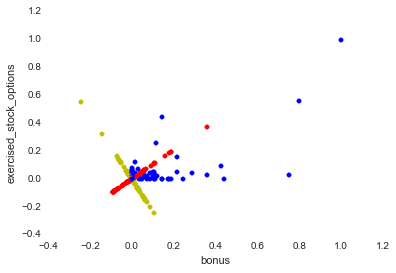

In [74]:
#each pca component contains a vector transformation to get from 
#the pca back to the original features
pc_1st = pca.components_[0]
pc_2nd = pca.components_[1]
pc_3rd = pca.components_[2]


#transform the original 8 features into the principle features
feature_train_scaled_pca = pca.transform(feature_train_scaled)

#use zip here to combine each list into a list of tuples
#iterate through the list of transformed features.
#ii contains the aggregated principle components, and jj contains the 
#original data points for each feature.  
for ii, jj in zip(feature_train_scaled_pca, feature_test_scaled):
    #plot the 
    plt.scatter(pc_1st[0]*ii[0], pc_1st[1]*ii[0], color="r")
    plt.scatter(pc_2nd[0]*ii[1], pc_2nd[1]*ii[1], color="y")
    plt.scatter(jj[0], jj[1], color="b")

plt.xlabel(financial_features[1+0])
plt.ylabel(financial_features[1+1])
plt.show()
    

####And for comparison, we plot the top two pinciple components of the 3rd and 4th features

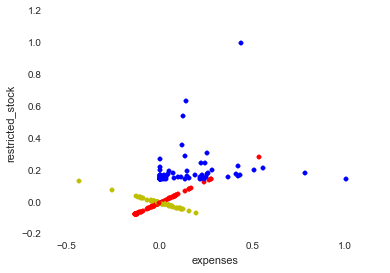

In [75]:
#use zip here to combine each list into a list of tuples
#iterate through the list of transformed original features
for ii, jj in zip(feature_train_scaled_pca, feature_test_scaled):
    #plot the 
    plt.scatter(pc_1st[2]*ii[0], pc_1st[3]*ii[0], color="r")
    plt.scatter(pc_2nd[2]*ii[1], pc_2nd[3]*ii[1], color="y")
    plt.scatter(jj[2], jj[3], color="b")

plt.xlabel(financial_features[1+2])
plt.ylabel(financial_features[1+3])
plt.show()

####Dimensionality Reduction without normalization
Now let's see what happens when we use PCA without applying feature scaling.  

In [76]:
pca.fit(feature_train)

pca.explained_variance_ratio_ #this contains the eigenvalues

array([ 0.80825844,  0.11632032,  0.06467271])

So the first 3 principle components explain 80%, 12% and 6% of the variance, respectively 

In [77]:
#extract each of the three principle components each of which contain the linear 
#transformation needed to get from the back to the principle components for each 
#of the features
pc_1st = pca.components_[0]
pc_2nd = pca.components_[1]
pc_3rd = pca.components_[2]

print pc_1st, "\n", pc_2nd, "\n", pc_3rd

[ 0.02322436  0.64470443  0.00088744  0.10552575  0.0063983   0.0918702
  0.751132  ] 
[-0.29633846  0.23746394 -0.00411335 -0.28414721 -0.04637288 -0.8778849
 -0.0469626 ] 
[ -1.84997711e-01  -4.39815260e-01   1.68916408e-04   7.55945635e-01
  -3.88690539e-03  -3.17895355e-01   3.15930352e-01]


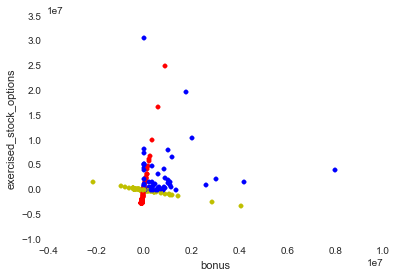

In [78]:
#transform the original 8 features into the principle features
transformed_features = pca.transform(feature_train)

#use zip here to combine each list into a list of tuples
#iterate through the list of transformed original features
for ii, jj in zip(transformed_features, feature_train):
    #ii has a length of n_components and represents a vector transformation of 
    plt.scatter(pc_1st[0]*ii[0], pc_1st[1]*ii[0], color="r")
    plt.scatter(pc_2nd[0]*ii[1], pc_2nd[1]*ii[1], color="y")
    plt.scatter(jj[0], jj[1], color="b")

plt.xlabel(financial_features[1+0])
plt.ylabel(financial_features[1+1])
plt.show()    

What happens when we remove the "linear transformation"?

## Task 4 & 5:  Explore and Tune the Classifier

####Use SVM to classify poi's without normalization or feature selection

In [79]:
svm = LinearSVC()

svm = svm.fit(feature_train, target_train)

test_classifier(svm, enron_data, financial_features)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
	Accuracy: 0.67373	Precision: 0.16674	Recall: 0.36200	F1: 0.22832	F2: 0.29331
	Total predictions: 15000	True positives:  724	False positives: 3618	False negatives: 1276	True negatives: 9382



####Exploring different approaches with pipeline notation
Now let's use the pipeline notation to explore different combinations of normalization, feature selection, and classifiers.

In [80]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), ('classifier', LinearSVC())])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86247	Precision: 0.41509	Recall: 0.07700	F1: 0.12990	F2: 0.09198
	Total predictions: 15000	True positives:  154	False positives:  217	False negatives: 1846	True negatives: 12783

0.833999872208


In [81]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('dim_reduction', pca), 
                     ('classifier', LinearSVC())])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('dim_reduction', PCA(copy=True, n_components=3, whiten=False)), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86853	Precision: 0.53553	Recall: 0.10550	F1: 0.17627	F2: 0.12569
	Total predictions: 15000	True positives:  211	False positives:  183	False negatives: 1789	True negatives: 12817

0.924999952316


In [82]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('dim_reduction', pca), 
                     ('classifier', LinearSVC(C=10))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('dim_reduction', PCA(copy=True, n_components=3, whiten=False)), ('classifier', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86653	Precision: 0.49772	Recall: 0.10900	F1: 0.17884	F2: 0.12918
	Total predictions: 15000	True positives:  218	False positives:  220	False negatives: 1782	True negatives: 12780

2.68700003624


In [83]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('dim_reduction', pca), 
                     ('classifier', LinearSVC(C=100))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('dim_reduction', PCA(copy=True, n_components=3, whiten=False)), ('classifier', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86693	Precision: 0.50461	Recall: 0.10950	F1: 0.17995	F2: 0.12983
	Total predictions: 15000	True positives:  219	False positives:  215	False negatives: 1781	True negatives: 12785

4.20700001717


In [84]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=3)), 
                     ('classifier', LinearSVC())])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=3, score_func=<function chi2 at 0x000000002A0C0C18>)), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.87267	Precision: 0.61480	Recall: 0.12050	F1: 0.20151	F2: 0.14359
	Total predictions: 15000	True positives:  241	False positives:  151	False negatives: 1759	True negatives: 12849

1.42199993134


In [85]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(f_regression, k=3)), 
                     ('classifier', LinearSVC())])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=3, score_func=<function f_regression at 0x000000002A0C0C88>)), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86693	Precision: 0.50433	Recall: 0.11650	F1: 0.18928	F2: 0.13767
	Total predictions: 15000	True positives:  233	False positives:  229	False negatives: 1767	True negatives: 12771

1.1930000782


In [86]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', RFE(Lasso())), 
                     ('classifier', LinearSVC())])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', RFE(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86673	Precision: 0.50216	Recall: 0.05800	F1: 0.10399	F2: 0.07047
	Total predictions: 15000	True positives:  116	False positives:  115	False negatives: 1884	True negatives: 12885

3.11899995804


In [87]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(f_regression, k=2)), 
                     ('classifier', AdaBoostClassifier(n_estimators = 100))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=2, score_func=<function f_regression at 0x000000002A0C0C88>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None))])
	Accuracy: 0.82507	Precision: 0.30051	Recall: 0.23500	F1: 0.26375	F2: 0.24571
	Total predictions: 15000	True positives:  470	False positives: 1094	False negatives: 1530	True negatives: 11906

49.118999958


In [88]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(f_classif, k=2)), 
                     ('classifier', AdaBoostClassifier(n_estimators = 100))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=2, score_func=<function f_classif at 0x000000002A0C0B38>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None))])
	Accuracy: 0.82487	Precision: 0.29917	Recall: 0.23350	F1: 0.26229	F2: 0.24422
	Total predictions: 15000	True positives:  467	False positives: 1094	False negatives: 1533	True negatives: 11906

48.7969999313


In [89]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(f_regression, k=2)), 
                     ('classifier', RandomForestClassifier(n_estimators = 100))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=2, score_func=<function f_regression at 0x000000002A0C0C88>)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_featu...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.83187	Precision: 0.28746	Recall: 0.17650	F1: 0.21871	F2: 0.19127
	Total predictions: 15000	True positives:  353	False positives:  875	False negatives: 1647	True negatives: 12125

40.6080000401


In [90]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(f_classif, k=2)), 
                     ('classifier', RandomForestClassifier(n_estimators = 100))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)


print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=2, score_func=<function f_classif at 0x000000002A0C0B38>)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.83193	Precision: 0.28873	Recall: 0.17800	F1: 0.22023	F2: 0.19279
	Total predictions: 15000	True positives:  356	False positives:  877	False negatives: 1644	True negatives: 12123

40.492000103


In [91]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=4)), 
                     ('classifier', AdaBoostClassifier(n_estimators = 200))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=4, score_func=<function chi2 at 0x000000002A0C0C18>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None))])
	Accuracy: 0.82987	Precision: 0.33841	Recall: 0.28900	F1: 0.31176	F2: 0.29769
	Total predictions: 15000	True positives:  578	False positives: 1130	False negatives: 1422	True negatives: 11870

100.031000137


In [92]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=4)), 
                     ('classifier', RandomForestClassifier(n_estimators = 1000))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=4, score_func=<function chi2 at 0x000000002A0C0C18>)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='aut...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.87827	Precision: 0.57838	Recall: 0.32100	F1: 0.41286	F2: 0.35236
	Total predictions: 15000	True positives:  642	False positives:  468	False negatives: 1358	True negatives: 12532

413.315999985


In [93]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=4)), 
                     ('classifier', RandomForestClassifier(n_estimators = 200))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=4, score_func=<function chi2 at 0x000000002A0C0C18>)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='aut...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.87673	Precision: 0.56808	Recall: 0.31500	F1: 0.40528	F2: 0.34581
	Total predictions: 15000	True positives:  630	False positives:  479	False negatives: 1370	True negatives: 12521

91.7309999466


In [94]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=4)), 
                     ('classifier', RandomForestClassifier(n_estimators = 50, max_features=3))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=4, score_func=<function chi2 at 0x000000002A0C0C18>)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, m...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.86773	Precision: 0.50654	Recall: 0.31000	F1: 0.38462	F2: 0.33608
	Total predictions: 15000	True positives:  620	False positives:  604	False negatives: 1380	True negatives: 12396

24.1010000706


In [95]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=4)), 
                     ('classifier', RandomForestClassifier(n_estimators = 200, max_features=3))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=4, score_func=<function chi2 at 0x000000002A0C0C18>)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, m...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.87113	Precision: 0.52708	Recall: 0.32600	F1: 0.40284	F2: 0.35293
	Total predictions: 15000	True positives:  652	False positives:  585	False negatives: 1348	True negatives: 12415

88.5239999294


In [96]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=4)), 
                     ('classifier', RandomForestClassifier(n_estimators = 1000, max_features=3))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=4, score_func=<function chi2 at 0x000000002A0C0C18>)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, m...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.87173	Precision: 0.53050	Recall: 0.33050	F1: 0.40727	F2: 0.35745
	Total predictions: 15000	True positives:  661	False positives:  585	False negatives: 1339	True negatives: 12415

434.800000191


In [97]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=4)), 
                     ('classifier', KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', 
                                                         leaf_size=30, p=2, metric='minkowski'))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)


Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=4, score_func=<function chi2 at 0x000000002A0C0C18>)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform'))])
	Accuracy: 0.82360	Precision: 0.34426	Recall: 0.35700	F1: 0.35052	F2: 0.35438
	Total predictions: 15000	True positives:  714	False positives: 1360	False negatives: 1286	True negatives: 11640



In [98]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=4)), 
                     ('classifier', KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', 
                                                         leaf_size=30, p=1, metric='minkowski'))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=4, score_func=<function chi2 at 0x000000002A0C0C18>)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=1, weights='uniform'))])
	Accuracy: 0.83980	Precision: 0.39230	Recall: 0.36700	F1: 0.37923	F2: 0.37180
	Total predictions: 15000	True positives:  734	False positives: 1137	False negatives: 1266	True negatives: 11863

1.49799990654


In [104]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=3)), 
                     ('classifier', KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', 
                                                         leaf_size=30, p=1, metric='minkowski'))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=3, score_func=<function chi2 at 0x000000002A0C0C18>)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=1, weights='uniform'))])
	Accuracy: 0.83607	Precision: 0.38462	Recall: 0.38250	F1: 0.38355	F2: 0.38292
	Total predictions: 15000	True positives:  765	False positives: 1224	False negatives: 1235	True negatives: 11776

1.42700004578


####Select the tuned algorithm with good accuracy, precision and recall

In [101]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=3)), 
                     ('classifier', RandomForestClassifier(n_estimators = 50, max_features=3))])

pipeline.fit(feature_train, target_train)
prediction = pipeline.predict(feature_test)

test_classifier(pipeline, enron_data, financial_features)

### Dump your classifier, dataset, and features_list so 
### anyone can run/check your results.

dump_classifier_and_data(pipeline, enron_data, financial_features)
print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=3, score_func=<function chi2 at 0x000000002A0C0C18>)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, m...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.86507	Precision: 0.49233	Recall: 0.38500	F1: 0.43210	F2: 0.40255
	Total predictions: 15000	True positives:  770	False positives:  794	False negatives: 1230	True negatives: 12206

24.0789999962


###Additional methods to explore include:

* using k-fold cross-validation to improve model validation